In [89]:
import datetime
import pandas as pd
import numpy as np
# import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
#import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [90]:
import os
import distutils.sysconfig
os.system('ln -sf /Applications/Wind\ API.app/Contents/python/WindPy.py' + ' ' + distutils.sysconfig.get_python_lib())
os.system('ln -sf ~/Library/Containers/com.wind.mac.api/Data/.Wind ~/.Wind')

1

In [91]:
from WindPy import w

w.start() # 默认命令超时时间为120秒，如需设置超时时间可以加入waitTime参数，例如waitTime=60,即设置命令超时时间为60秒 
w.isconnected() # 判断WindPy是否已经登录成功

True

### 更新日期 都是21号

In [92]:
startdate = '2014-01-03'
today = datetime.date.today().strftime('%Y-%m-%d') 
#enddate = today
enddate = '2024-7-21'

In [93]:
k=pd.to_datetime(enddate)
k.day

21

In [94]:
######################################################################
#                             被预测变量                              #
######################################################################
errorcode, t10y = w.edb("S0059749", startdate, enddate, "Fill=Previous", usedf=True)
t10y.columns = ['10y']
t10y.index = pd.to_datetime(t10y.index)
###【原代码 S0059749 vs. M0325687】

#------------------------------------------------------------------
# y变量：从每月的预测日到下一月预测日的现券收益率变动
#------------------------------------------------------------------

import datetime
t10y['date'] = t10y.index
t10y['ym'] = t10y['date'].apply(lambda x: x.year*100 + x.month if x.day<21 else (x+datetime.timedelta(days=20)).year*100 + (x+datetime.timedelta(days=20)).month)
t10y_copy = t10y.copy()
t10y_copy.dropna(inplace=True)
t10y_copy['ym'] = t10y_copy['ym'].astype('int64')
t10y_copy.drop_duplicates('ym',keep='last',inplace=True)
t10y['ym'] = t10y['ym'].shift(1)
t10y.dropna(inplace=True)
t10y['ym'] = t10y['ym'].astype('int64')
t10y.drop_duplicates('ym',keep='last',inplace=True)
t10y['10y_next'] = t10y['10y'].shift(-1)
t10y['y_true'] = (t10y['10y']<t10y['10y_next'])*1
t10y.set_index('ym',inplace=True)
# t10y.dropna(inplace=True)
y_data = t10y.fillna(method='ffill')

In [95]:
y_data

,10y,date,10y_next,y_true
ym,,,,
201401,4.5423,2014-01-21,4.5234,0
201402,4.5234,2014-02-21,4.5044,0
201403,4.5044,2014-03-21,4.2997,0
201404,4.2997,2014-04-21,4.1770,0
201405,4.1770,2014-05-21,4.0515,0
...,...,...,...,...
202403,2.2851,2024-03-21,2.2435,0
202404,2.2435,2024-04-22,2.3141,1
202405,2.3141,2024-05-21,2.2571,0


In [96]:
# ####################################################################
#                              输入变量                               #
######################################################################

# 月度指标-wind获取
errorcode, mondata = w.edb("M0000138,M0061603,M0017126,M5207838,G1000116,M0000273,M0000357,M5440435,S0029657,S0073290,S0073293,S0073297,S0073300,S2704485,S0073285,M0012303,M0001440,M0061665,M0061666,M0000607,M0000609,M0000611,M0000545,M0000557,M0000559,M0000612,M0085932,M0001227,M0001228,M0001232,M0001383,M0001385,M0009973,M0043417,M0043418,S6426477,S6405195,M5530000", startdate, enddate, usedf=True)
mondata.rename(columns={'M0000138':'caixin_pmi_manu','M0061603':'caixin_pmi_service','M0017126':'pmi_manu',\
                        'M5207838':'pmi_service','G1000116':'oecd','M0000273':'investment',\
                        'M0000357':'investment_manu','M5440435':'investment_infra',\
                        'S0029657':'investment_re','S0073290':'re_construct','S0073293':'re_new',\
                        'S0073297':'re_complete','S0073300':'re_sales','S2704485':'re_baichen',\
                        'S0073285':'re_price','M0012303':'confidence','M0001440':'retail',\
                        'M0061665':'retail_city','M0061666':'retail_rural','M0000607':'export',\
                        'M0000609':'import','M0000611':'trade_surplus','M0000545':'industry_add',\
                        'M0000557':'industry_profit','M0000559':'industry_loss','M0000612':'cpi',\
                        'M0085932':'cpi_core','M0001227':'ppi','M0001228':'ppi_product',\
                        'M0001232':'ppi_live','M0001383':'m1','M0001385':'m2',\
                        'M0009973':'new_loan','M0043417':'short_loan','M0043418':'long_loan',\
                        'S6426477':'cangchu','S6405195':'wuliu','M5530000':'EPMI'},inplace=True)
mondata.index = pd.to_datetime(mondata.index)

# 月度指标-拼接社融数据
errorcode, funding = w.edb("M5525763", '2016-01-01', enddate, usedf=True)
funding.columns = ['funding']
funding.index = pd.to_datetime(funding.index)
fundhist = pd.read_excel(r'社融历史.xlsx')
fundhist.dropna(inplace=True)
fundhist.set_index('date',inplace=True)
fundhist = fundhist[startdate:]
fundhist.drop(['funding_size'],axis=1,inplace=True)
fundhist = fundhist*100
fundhist = fundhist.round(1)
fundhist=pd.concat([fundhist,funding])

mondata = mondata.join(fundhist)

# 月度指标-使index保持一致
mondata['date'] = mondata.index
mondata['ym'] = mondata['date'].apply(lambda x: (x+datetime.timedelta(days=20)).year*100 + (x+datetime.timedelta(days=20)).month)
mondata['ym'] = mondata['ym'].astype('int64')
mondata.drop('date',axis=1,inplace=True)
mondata.set_index('ym',inplace=True)
#mondata = mondata[:-1]
mondata

,caixin_pmi_manu,caixin_pmi_service,pmi_manu,pmi_service,oecd,investment,investment_manu,investment_infra,investment_re,re_construct,...,ppi_live,m1,m2,new_loan,short_loan,long_loan,cangchu,wuliu,EPMI,funding
ym,,,,,,,,,,,,,,,,,,,,,
201402,49.5,50.7,50.5,51.5,100.7062,NaN,NaN,NaN,NaN,NaN,...,-0.3500,1.2,13.2,13190.0,295640.52,407001.23,NaN,55.2,55.7,18.9
201403,48.5,51.0,50.2,53.8,100.5990,17.9,15.1225,18.769100,19.3,16.3,...,-0.3299,6.9,13.3,6448.0,298051.43,411142.82,NaN,55.5,57.6,18.6
201404,48.0,51.9,50.3,52.8,100.4946,17.6,15.2000,20.882800,16.8,14.2,...,-0.2092,5.4,12.1,10497.0,302593.28,416371.37,NaN,55.8,57.5,17.6
201405,48.1,51.4,50.4,53.4,100.3951,17.3,15.2000,20.853900,16.4,12.8,...,-0.0575,5.5,13.2,7745.0,304073.52,421500.02,NaN,57.7,55.8,17.0
201406,49.4,50.7,50.8,54.4,100.3104,17.2,14.2000,23.016000,14.7,12.0,...,0.1690,5.7,13.4,8708.0,305533.36,427000.27,NaN,55.2,53.4,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202404,51.1,52.7,50.8,52.4,100.3625,4.5,9.9000,8.754397,-9.5,-11.1,...,-1.0000,1.1,8.3,30900.0,638665.93,1657489.07,52.6,51.5,54.8,8.7
202405,51.4,52.5,50.4,50.3,100.3186,4.2,9.7000,7.783003,-9.8,-10.8,...,-0.9000,-1.4,7.2,7300.0,631071.36,1659904.47,49.0,52.4,53.0,8.3
202406,51.7,54.0,49.5,50.5,100.2842,4.0,9.6000,6.679178,-10.1,-11.6,...,-0.8000,-4.2,7.0,9500.0,630057.30,1665430.62,48.4,51.8,52.7,8.4


In [97]:
# 日度指标
errorcode, dailydata = w.edb("M0017145,M1001795,M1006337,M1000529,M1000530,M0342074,S0059776,M0000271,M0000185,M0067855", startdate, enddate, usedf=True)
dailydata.rename(columns={'M0017145':'shibor1y','M1001795':'R007','M1006337':'DR007','M1000529':'note3m','M1000530':'note6m','M0342074':'pe_ratio','S0059776':'corpbond','M0000271':'dxy','M0000185':'usdrmb','M0067855':'usdrmb_close'},inplace=True)
dailydata.index = pd.to_datetime(dailydata.index)
dailydata['FED'] = 1 / dailydata['pe_ratio'] / dailydata['corpbond']

# R007和DR007转换为滤波
lvbo = dailydata.copy()
lvbo = lvbo[['R007','DR007']]
lvbo['date'] = pd.to_datetime(lvbo.index)
lvbo = lvbo.sort_values('date', ascending=False)
lvbo = lvbo.dropna()
t1 = datetime.datetime(2015,1,16)
X = lvbo['date'][lvbo['date']>=t1]
length = len(lvbo)
def hp(y, lamb=10):
    def D_matrix(N):
        #(N-1,N) 元素全为0
        D = np.zeros((N-1,N))
        #后(N-1,N-1)对角线元素置1
        D[:,1:] = np.eye(N-1)
        #前(N-1,N-1)对角线元素置-1
        D[:,:-1] -= np.eye(N-1)
        """D1
        [[-1.  1.  0. ...  0.  0.  0.]
         [ 0. -1.  1. ...  0.  0.  0.]
         [ 0.  0. -1. ...  0.  0.  0.]
         ...
         [ 0.  0.  0. ...  1.  0.  0.]
         [ 0.  0.  0. ... -1.  1.  0.]
         [ 0.  0.  0. ...  0. -1.  1.]]
        """
        return D
    N = len(y)
    D1 = D_matrix(N)
    D2 = D_matrix(N-1)
    #@是矩阵乘法  D2.shape = (N-2,N-1) D1.shape = (N-1,N) 所以 D.shape = (N-2,N) 
    D = D2 @ D1
    # G = [i+λF]*-1Y
    #np.linalg.inv为矩阵求逆 套用公式 D.T@D = F F.shape=(N,N)
    g = np.linalg.inv((np.eye(N)+lamb*D.T@D))@ y
    return g
Y1 = lvbo['DR007'][:length+10]
Y2 = lvbo['R007'][:length+10]
g1 = hp(Y1,1000)[:length]
g2 = hp(Y2,1000)[:length]
result2 = pd.DataFrame({'DR007_lvbo':g1,'R007_lvbo':g2})
X = lvbo.index
result2 = result2.set_index(X)
result2.index = result2.index.map(str)
def request_date(x):
    return x[0:10]
result2.index = result2.index.map(request_date)
result2['date'] = pd.to_datetime(result2.index)
result2 = result2.sort_values('date', ascending=True)
result2.index = pd.to_datetime(result2.index)
dailydata = dailydata.join(result2)

# 日度指标-使index保持一致
dailydata['date'] = dailydata.index
dailydata['ym'] = dailydata['date'].apply(lambda x: x.year*100 + x.month if x.day<21 else (x+datetime.timedelta(days=21)).year*100 + (x+datetime.timedelta(days=21)).month)
dailydata.drop(['date','pe_ratio','corpbond','R007','DR007'],axis=1,inplace=True)
dailydata

# 日频取平均转换为月频
shibor1y = dailydata.groupby('ym')[['shibor1y']].mean()
R007_lvbo = dailydata.groupby('ym')[['R007_lvbo']].mean()
DR007_lvbo = dailydata.groupby('ym')[['DR007_lvbo']].mean()
note3m = dailydata.groupby('ym')[['note3m']].mean()
note6m = dailydata.groupby('ym')[['note6m']].mean()
FED = dailydata.groupby('ym')[['FED']].mean()
dxy = dailydata.groupby('ym')[['dxy']].mean()
usdrmb = dailydata.groupby('ym')[['usdrmb']].mean()
usdrmb_close = dailydata.groupby('ym')[['usdrmb_close']].mean()
X_daily = shibor1y.join([R007_lvbo,DR007_lvbo,note3m,note6m,FED,dxy,usdrmb,usdrmb_close])
X_daily

,shibor1y,R007_lvbo,DR007_lvbo,note3m,note6m,FED,dxy,usdrmb,usdrmb_close
ym,,,,,,,,,
201401,4.992900,NaN,NaN,6.094933,6.083942,0.018292,80.867500,6.103417,6.050233
201402,5.000130,NaN,NaN,5.676400,5.734310,0.018435,80.647391,6.107539,6.060206
201403,5.000055,NaN,NaN,5.021735,5.096875,0.020086,79.896000,6.127165,6.144030
201404,5.000000,NaN,NaN,4.896880,5.096865,0.019482,79.966667,6.151080,6.211555
201405,5.001143,NaN,NaN,4.501467,4.783295,0.020871,79.763182,6.159575,6.238605
...,...,...,...,...,...,...,...,...,...
202404,2.228500,2.059843,1.877013,2.137067,2.184462,0.031492,104.925591,7.097340,7.230110
202405,2.097975,1.902917,1.872961,2.004640,2.036330,0.031105,105.338005,7.103794,7.232721
202406,2.087727,1.901769,1.856298,1.960877,1.990664,0.031846,104.871078,7.111418,7.248532


In [98]:
#print(t10y_copy.columns)

In [99]:
print(t10y_copy)
print(t10y_copy.index)

               10y       date      ym
2014-01-20  4.5923 2014-01-20  201401
2014-02-20  4.5336 2014-02-20  201402
2014-03-20  4.5195 2014-03-20  201403
2014-04-18  4.2997 2014-04-18  201404
2014-05-20  4.1770 2014-05-20  201405
...            ...        ...     ...
2024-04-19  2.2540 2024-04-19  202404
2024-05-20  2.3105 2024-05-20  202405
2024-06-20  2.2445 2024-06-20  202406
2024-07-19  2.2614 2024-07-19  202407
2024-07-22  2.2461 2024-07-22  202408

[128 rows x 3 columns]
DatetimeIndex(['2014-01-20', '2014-02-20', '2014-03-20', '2014-04-18',
               '2014-05-20', '2014-06-20', '2014-07-18', '2014-08-20',
               '2014-09-19', '2014-10-20',
               ...
               '2023-11-20', '2023-12-20', '2024-01-19', '2024-02-20',
               '2024-03-20', '2024-04-19', '2024-05-20', '2024-06-20',
               '2024-07-19', '2024-07-22'],
              dtype='datetime64[ns]', length=128, freq=None)


In [100]:
# 活跃券收益率（用于计算量价指标）
errorcode, dailytbond = w.wsd("GZHY.WI", "CLOSE", startdate, enddate, usedf=True)         
def ma(data,w):
    result=[]
    for i in range(len(data)-w+1):
        ave=0
        for j in range(w):
            ave+=data[i+j]
        ave/=w
        result.append(ave)
    return result
tbond = dailytbond.fillna(0)
ma5 = [0] * 4 + ma(tbond['CLOSE'],5)
ma10 = [0] * 9 + ma(tbond['CLOSE'],10)
ma20 = [0] * 19 + ma(tbond['CLOSE'],20)
df = pd.DataFrame({'ma5': ma5, 'ma10': ma10, 'ma20': ma20}, index = tbond.index)
df.replace(0, np.nan, inplace=True)
tbond = tbond.join(df)

n = 25
high_max_index = tbond['CLOSE'].rolling(n).apply(lambda x: np.argmax(x), raw=True)
low_min_index = tbond['CLOSE'].rolling(n).apply(lambda x: np.argmin(x), raw=True)
aroon_up = (high_max_index+1) / n * 100
aroon_down = (low_min_index+1) / n * 100
tbond['Aroon_Up'] = aroon_up
tbond['Aroon_Down'] = aroon_down
tbond.drop(['CLOSE'],axis=1,inplace=True)

# 获取预测日前一天（20号）的量价指标
#t10y_copy = t10y_copy.set_index('date')
X_tech = pd.merge(t10y_copy, tbond, left_index=True, right_index=True, how='inner')
X_tech['date'] = X_tech.index
X_tech['ym'] = X_tech['date'].apply(lambda x: x.year*100 + x.month)
X_tech.set_index('ym',inplace=True)
X_tech.drop(['10y','date'],axis=1,inplace=True)
X_tech

,ma5,ma10,ma20,Aroon_Up,Aroon_Down
ym,,,,,
201401,4.57354,4.59279,NaN,NaN,NaN
201402,4.52002,4.50151,4.513880,8.0,48.0
201403,4.46200,4.45800,4.458555,16.0,40.0
201404,4.46500,4.50015,4.489715,60.0,32.0
201405,4.25076,4.21447,4.280360,4.0,72.0
...,...,...,...,...,...
202403,2.33050,2.32370,2.341025,8.0,60.0
202404,2.26310,2.27620,2.292575,4.0,100.0
202405,2.30220,2.30210,2.288675,52.0,36.0


In [101]:
# 将月频、日频和量价指标合并
X_raw = mondata.join([X_daily,X_tech])
X_raw

,caixin_pmi_manu,caixin_pmi_service,pmi_manu,pmi_service,oecd,investment,investment_manu,investment_infra,investment_re,re_construct,...,note6m,FED,dxy,usdrmb,usdrmb_close,ma5,ma10,ma20,Aroon_Up,Aroon_Down
ym,,,,,,,,,,,,,,,,,,,,,
201402,49.5,50.7,50.5,51.5,100.7062,NaN,NaN,NaN,NaN,NaN,...,5.734310,0.018435,80.647391,6.107539,6.060206,4.52002,4.50151,4.513880,8.0,48.0
201403,48.5,51.0,50.2,53.8,100.5990,17.9,15.1225,18.769100,19.3,16.3,...,5.096875,0.020086,79.896000,6.127165,6.144030,4.46200,4.45800,4.458555,16.0,40.0
201404,48.0,51.9,50.3,52.8,100.4946,17.6,15.2000,20.882800,16.8,14.2,...,5.096865,0.019482,79.966667,6.151080,6.211555,4.46500,4.50015,4.489715,60.0,32.0
201405,48.1,51.4,50.4,53.4,100.3951,17.3,15.2000,20.853900,16.4,12.8,...,4.783295,0.020871,79.763182,6.159575,6.238605,4.25076,4.21447,4.280360,4.0,72.0
201406,49.4,50.7,50.8,54.4,100.3104,17.2,14.2000,23.016000,14.7,12.0,...,4.677309,0.021654,80.474783,6.160632,6.236668,4.05280,4.03413,4.066605,8.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202404,51.1,52.7,50.8,52.4,100.3625,4.5,9.9000,8.754397,-9.5,-11.1,...,2.184462,0.031492,104.925591,7.097340,7.230110,2.26310,2.27620,2.292575,4.0,100.0
202405,51.4,52.5,50.4,50.3,100.3186,4.2,9.7000,7.783003,-9.8,-10.8,...,2.036330,0.031105,105.338005,7.103794,7.232721,2.30220,2.30210,2.288675,52.0,36.0
202406,51.7,54.0,49.5,50.5,100.2842,4.0,9.6000,6.679178,-10.1,-11.6,...,1.990664,0.031846,104.871078,7.111418,7.248532,2.27968,2.29189,2.299020,48.0,96.0


In [102]:
# 数据处理
#X_raw = mondata  #################【纯基本面模型】#################
# 1. 向下shift一格，e.g.11月的input是在9/20-10/20之间公布的8月工业企业利润/亏损数据
X_raw.loc[:,['industry_profit','industry_loss']] = X_raw.loc[:,['industry_profit','industry_loss']].shift(1)
#X_raw.drop(['note3m','note6m','FED'],axis=1,inplace=True)

# 2. 向前填充
X_raw.ffill(inplace=True)
X_raw.dropna(inplace=True)

In [103]:
X_raw

,caixin_pmi_manu,caixin_pmi_service,pmi_manu,pmi_service,oecd,investment,investment_manu,investment_infra,investment_re,re_construct,...,note6m,FED,dxy,usdrmb,usdrmb_close,ma5,ma10,ma20,Aroon_Up,Aroon_Down
ym,,,,,,,,,,,,,,,,,,,,,
201512,48.6,51.2,49.6,52.8,99.78864,10.2,8.4253,18.008300,1.3,1.8,...,3.110515,0.018293,98.858245,6.416085,6.422645,3.06598,3.03424,3.048645,4.0,80.0
201601,48.2,50.2,49.7,53.7,99.76213,10.0,8.1000,17.289500,1.0,1.3,...,2.790705,0.020753,98.641114,6.522005,6.535005,2.76700,2.78225,2.808750,8.0,80.0
201602,48.4,52.4,49.4,52.7,99.75711,10.0,8.1000,17.289500,1.0,1.3,...,2.828747,0.024061,97.573932,6.540971,6.559265,2.81900,2.55900,2.693250,68.0,80.0
201603,48.0,51.2,49.0,52.2,99.78277,10.2,7.5000,15.710100,3.0,5.9,...,2.698395,0.023257,97.013340,6.517320,6.520115,2.82600,2.85450,2.858875,64.0,4.0
201604,49.7,52.2,50.2,53.1,99.85286,10.7,6.4000,19.245600,6.2,5.8,...,2.750100,0.021922,94.895396,6.481873,6.483277,2.90500,2.90725,2.878375,84.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202404,51.1,52.7,50.8,52.4,100.36250,4.5,9.9000,8.754397,-9.5,-11.1,...,2.184462,0.031492,104.925591,7.097340,7.230110,2.26310,2.27620,2.292575,4.0,100.0
202405,51.4,52.5,50.4,50.3,100.31860,4.2,9.7000,7.783003,-9.8,-10.8,...,2.036330,0.031105,105.338005,7.103794,7.232721,2.30220,2.30210,2.288675,52.0,36.0
202406,51.7,54.0,49.5,50.5,100.28420,4.0,9.6000,6.679178,-10.1,-11.6,...,1.990664,0.031846,104.871078,7.111418,7.248532,2.27968,2.29189,2.299020,48.0,96.0


In [104]:
y_data.dropna(inplace=True)
y_data['y_true'] = y_data['y_true'].astype('int64')
#y_train_dataset = y_data.loc[X_raw.index[:-1],'y_true']
#y_data
y_data_reindexed = y_data.reindex(X_raw.index[:-1], method='ffill')
y_train_dataset = y_data_reindexed['y_true']

In [105]:
##### Logistic回归 #####

def EnsembleTrain(X_raw,y_train_dataset):

    y_pred_dict = dict()
    
    for m in range(window, X_raw.shape[0]):
       
        # --------------------------Input-----------------------------
        X_train = X_raw[m-window:m]
        y_train = y_train_dataset[m-window:m]
        X_test = pd.DataFrame(X_raw.iloc[m,:]).T
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Logistic回归
        log_clf = LogisticRegression(random_state=123)
        log_clf.fit(X_train,y_train)
        y_pred=log_clf.predict(X_test)

        # --------------------------Predict-----------------------------
        pred_ym = X_raw.index[m]
        y_pred_dict[pred_ym] = y_pred[0]

    return X_train, y_train, X_test, y_pred_dict

duration = 8
result_dict = {}
def process_data(data):
    if data['y_pred'] == data['y_true']:
        return abs(data['ytm_change'])
    else:
        return -abs(data['ytm_change'])
def process_data1(data):
    if data['y_pred'] == data['y_true']:
        if data['y_pred']!=0:
            return data['ytm_change']-data['ytm_change']
        else:
            return abs(data['ytm_change'])
    else:
        if data['y_pred']!=0:
            return data['ytm_change']-data['ytm_change']
        else:
            return -abs(data['ytm_change'])
        

In [106]:
# #原始模型代码跑这个
# for i in range(30,60):
#     window = i
#     X_train, y_train, X_test, y_pred_dict = EnsembleTrain(X_raw,y_train_dataset)
#     newpred = y_pred_dict.popitem()
#     evaluatedf = pd.DataFrame(y_pred_dict.values(),index=y_pred_dict.keys(),columns=['y_pred'])
#     result = pd.merge(evaluatedf, y_data, left_index=True, right_index=True)
#     result['ytm_change'] = result['10y_next'] - result['10y']
#     result['ytm_change'] = result.apply(process_data, axis=1)
#     result['price_change'] = result['ytm_change'] * duration
#     ASR = result['price_change'].mean() / result['price_change'].std() * np.sqrt(12)
#     result_dict[window] = ASR
    
# window = max(result_dict, key=result_dict.get)
# window

In [107]:
# #原始模型代码跑这个
# window = 56
# X_train, y_train, X_test, y_pred_dict = EnsembleTrain(X_raw,y_train_dataset)
# newpred = y_pred_dict.popitem()
# evaluatedf = pd.DataFrame(y_pred_dict.values(),index=y_pred_dict.keys(),columns=['y_pred'])
# result = pd.merge(evaluatedf, y_data, left_index=True, right_index=True)
# result['ytm_change'] = result['10y_next'] - result['10y']
# result['ytm_change'] = result.apply(process_data, axis=1)
# result['price_change'] = result['ytm_change'] * duration
# ASR = result['price_change'].mean() / result['price_change'].std() * np.sqrt(12)
# print('Window:', window)
# print('Annualized Sharpe ratio:', ASR)
# print('Votingclf out-of-sample accuracy score: {0:0.4f}'.format(accuracy_score(result['y_pred'],result['y_true'])))

In [108]:
# #原始模型代码跑这个
# result['price'] = 1
# result['price'] = result['price_change']/100
# result['price'] = result['price'].add(1).cumprod()
# result['price_date'] = result['date'].shift(-1)
# result.iloc[-1, -1] = pd.to_datetime(enddate)
# result['price_date'] = pd.to_datetime(result['price_date'])
# result.plot(x='price_date', y='price')
# plt.show()

In [109]:
# #优化模型代码跑这个
# for i in range(30,60):
#     window = i
#     X_train, y_train, X_test, y_pred_dict = EnsembleTrain(X_raw,y_train_dataset)
#     newpred = y_pred_dict.popitem()
#     evaluatedf = pd.DataFrame(y_pred_dict.values(),index=y_pred_dict.keys(),columns=['y_pred'])
#     result = pd.merge(evaluatedf, y_data, left_index=True, right_index=True)
#     result['ytm_change'] = result['10y_next'] - result['10y']
#     result['ytm_change'] = result.apply(process_data1, axis=1)
#     result['price_change'] = result['ytm_change'] * duration
#     ASR = result['price_change'].mean() / result['price_change'].std() * np.sqrt(12)
#     result_dict[window] = ASR
    
# window = max(result_dict, key=result_dict.get)
# window

In [110]:
#优化模型代码跑这个
window = 59
X_train, y_train, X_test, y_pred_dict = EnsembleTrain(X_raw,y_train_dataset)
newpred = y_pred_dict.popitem()
evaluatedf = pd.DataFrame(y_pred_dict.values(),index=y_pred_dict.keys(),columns=['y_pred'])
result = pd.merge(evaluatedf, y_data, left_index=True, right_index=True)
print(y_data)
result['ytm_change'] = result['10y_next'] - result['10y']
result['ytm_change'] = result.apply(process_data1, axis=1)
result['price_change'] = result['ytm_change'] * duration
ASR = result['price_change'].mean() / result['price_change'].std() * np.sqrt(12)
print('Window:', window)
print('Annualized Sharpe ratio:', ASR)
print('Votingclf out-of-sample accuracy score: {0:0.4f}'.format(accuracy_score(result['y_pred'],result['y_true'])))

           10y       date  10y_next  y_true
ym                                         
201401  4.5423 2014-01-21    4.5234       0
201402  4.5234 2014-02-21    4.5044       0
201403  4.5044 2014-03-21    4.2997       0
201404  4.2997 2014-04-21    4.1770       0
201405  4.1770 2014-05-21    4.0515       0
...        ...        ...       ...     ...
202403  2.2851 2024-03-21    2.2435       0
202404  2.2435 2024-04-22    2.3141       1
202405  2.3141 2024-05-21    2.2571       0
202406  2.2571 2024-06-21    2.2461       0
202407  2.2461 2024-07-22    2.2461       0

[127 rows x 4 columns]
Window: 59
Annualized Sharpe ratio: 1.2782508718524015
Votingclf out-of-sample accuracy score: 0.6444


In [111]:
newpred

(202408, 0)

In [112]:
result

,y_pred,10y,date,10y_next,y_true,ytm_change,price_change
202011,1,3.2650,2020-11-23,3.2652,1,0.0000,0.0000
202012,1,3.2652,2020-12-21,3.1335,0,0.0000,0.0000
202101,1,3.1335,2021-01-21,3.2736,1,0.0000,0.0000
202102,1,3.2736,2021-02-22,3.2309,0,0.0000,0.0000
202103,0,3.2309,2021-03-22,3.1530,0,0.0779,0.6232
202104,0,3.1530,2021-04-21,3.0876,0,0.0654,0.5232
202105,0,3.0876,2021-05-21,3.0953,1,-0.0077,-0.0616
202106,1,3.0953,2021-06-21,2.9184,0,0.0000,0.0000
202107,0,2.9184,2021-07-21,2.8672,0,0.0512,0.4096
202108,1,2.8672,2021-08-23,2.8639,0,0.0000,0.0000


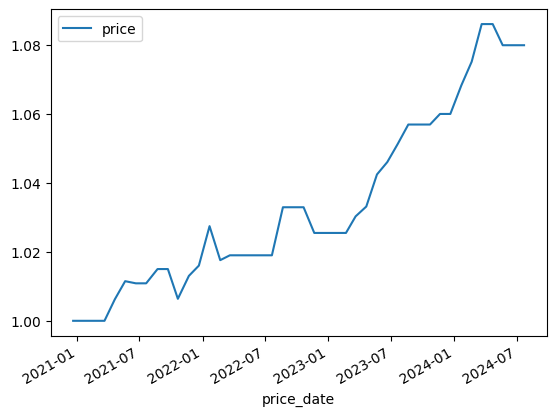

In [113]:
#优化模型代码跑这个
result['price'] = 1
result['price'] = result['price_change']/100
result['price'] = result['price'].add(1).cumprod()
result['price_date'] = result['date'].shift(-1)
result.iloc[-1, -1] = pd.to_datetime(enddate)
result['price_date'] = pd.to_datetime(result['price_date'])
result.plot(x='price_date', y='price')
plt.show()

In [114]:
result.to_excel('yue2.xlsx')

In [115]:
errorcode, t10y = w.edb("S0059749", startdate, enddate, "Fill=Previous", usedf=True)
t10y

,CLOSE
2014-01-03,4.6415
2014-01-06,4.6569
2014-01-07,4.6420
2014-01-08,4.5919
2014-01-09,4.5969
...,...
2024-07-16,2.2613
2024-07-17,2.2598
2024-07-18,2.2673
2024-07-19,2.2614
